 Generate a synthetic time series, composed of a mixture of sinusoidal signals with different frequencies and random noise.

In [1]:
#Generate Synthetic Time Series
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time

def generate_signal(N, freqs=[50, 120, 300], noise_level=0.5, fs=1000):
    """
    Generate a synthetic signal with given frequencies and additive noise.
    N : length of the signal
    freqs : list of sinusoidal frequencies
    noise_level : amplitude of noise
    fs : sampling frequency
    """
    t = np.arange(N) / fs
    signal = np.zeros(N)
    for f in freqs:
        signal += np.sin(2 * np.pi * f * t)
    signal += noise_level * np.random.randn(N)
    return signal, fs

(i) Transform the time series to the frequency domain using Fast Fourier Transform (FFT)

(ii) Compare the execution time of GPU-based FFT with a CPU-based implementation

In [2]:
#FFT on CPU and GPU
def compare_fft(signal):
    N = len(signal)

    # CPU FFT
    start_cpu = time.time()
    fft_cpu = np.fft.fft(signal)
    end_cpu = time.time()
    cpu_time = end_cpu - start_cpu

    # GPU FFT
    signal_gpu = cp.array(signal)
    start_gpu = time.time()
    fft_gpu = cp.fft.fft(signal_gpu)
    cp.cuda.Stream.null.synchronize()  # ensure GPU finishes
    end_gpu = time.time()
    gpu_time = end_gpu - start_gpu

    return fft_cpu, cp.asnumpy(fft_gpu), cpu_time, gpu_time

(iii) Plot the magnitude spectrum to identify the dominant frequencies

In [3]:
#Plot Magnitude Spectrum
def plot_spectrum(fft_result, fs, N, title):
    freqs = np.fft.fftfreq(N, 1/fs)
    magnitude = np.abs(fft_result)

    plt.figure(figsize=(10, 4))
    plt.plot(freqs[:N//2], magnitude[:N//2], lw=1.2)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

Repeat the analysis for time series of lengths 10⁵,10⁶, and 5×10⁶


=== Testing N = 100000 ===
CPU FFT Time: 0.0068 s
GPU FFT Time: 0.6025 s


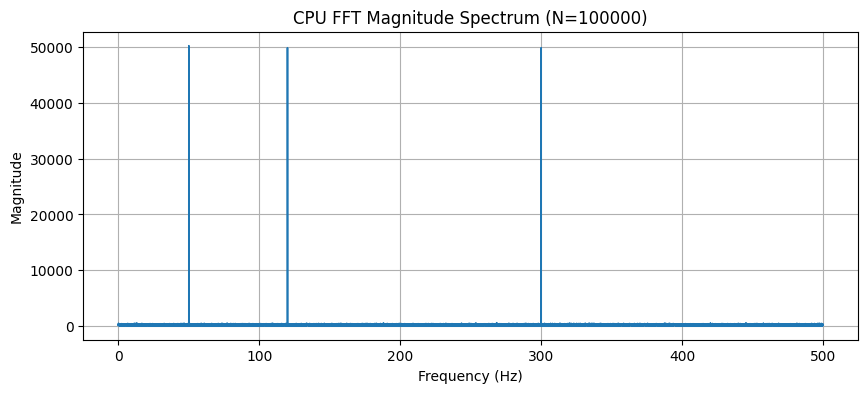

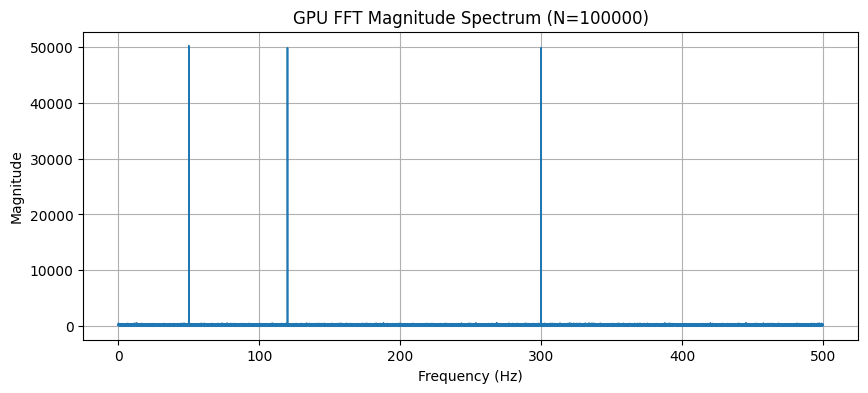

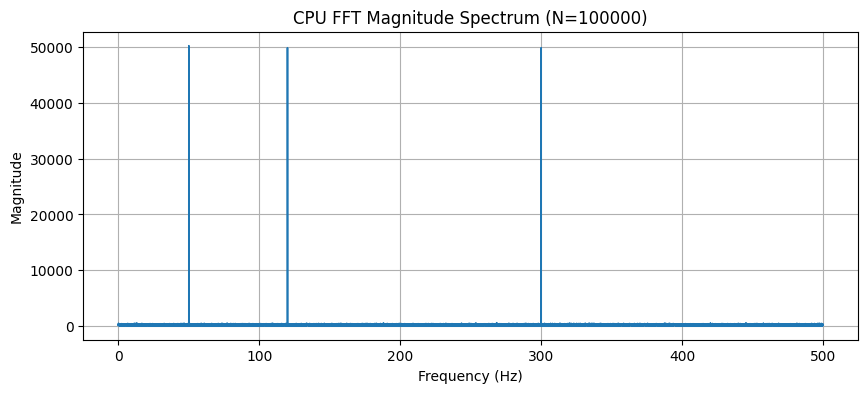

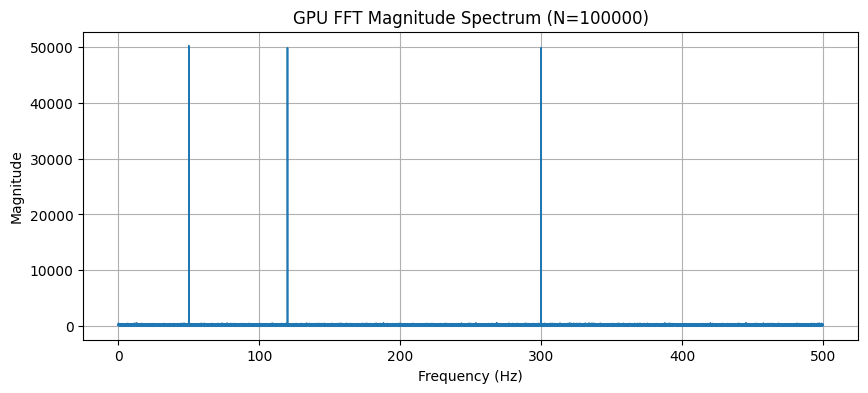


=== Testing N = 1000000 ===
CPU FFT Time: 0.0449 s
GPU FFT Time: 0.0045 s


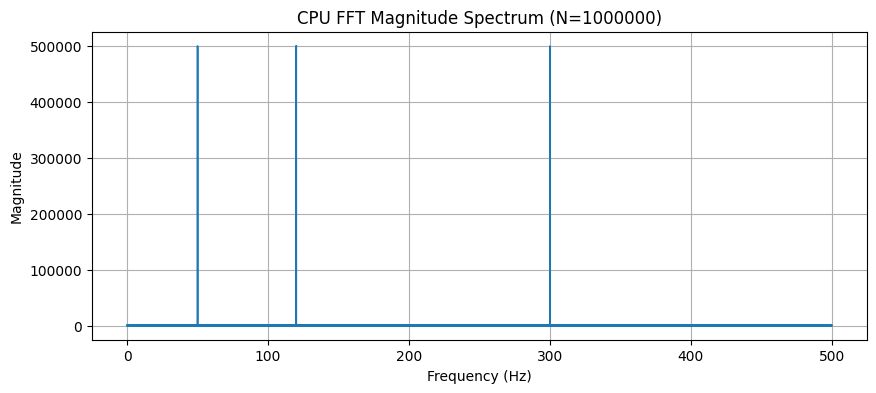

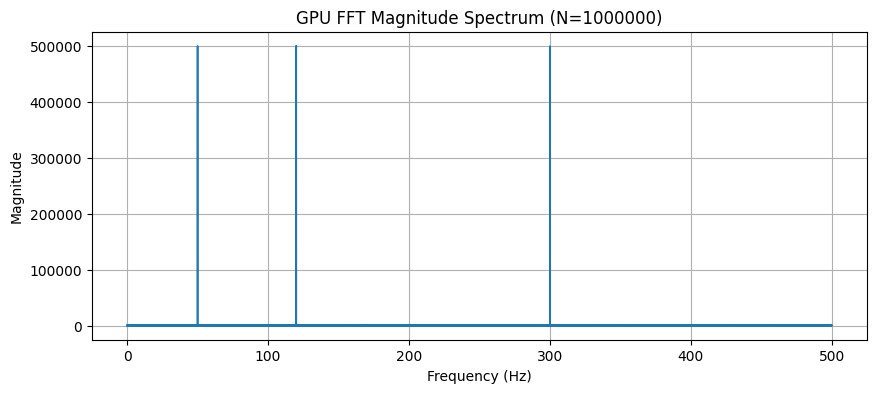


=== Testing N = 5000000 ===
CPU FFT Time: 0.2832 s
GPU FFT Time: 0.0212 s


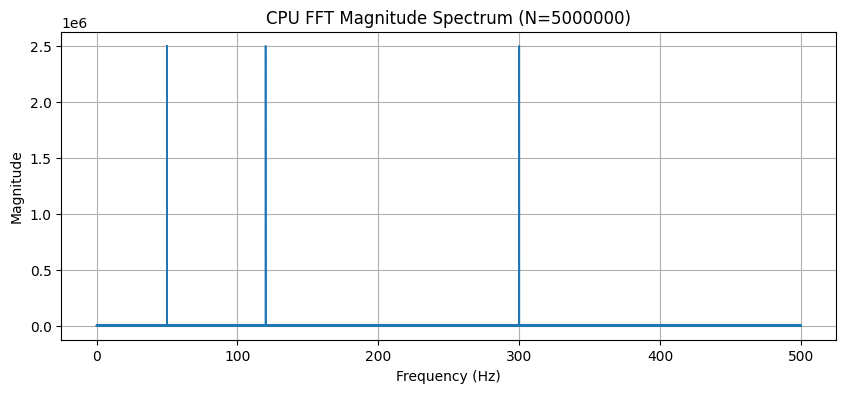

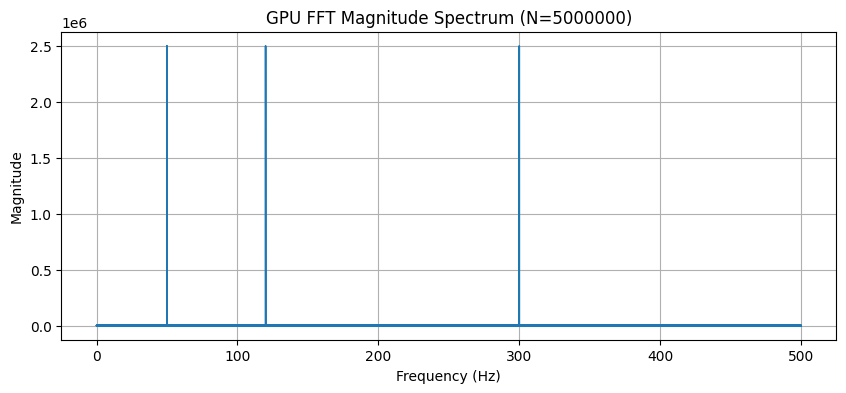

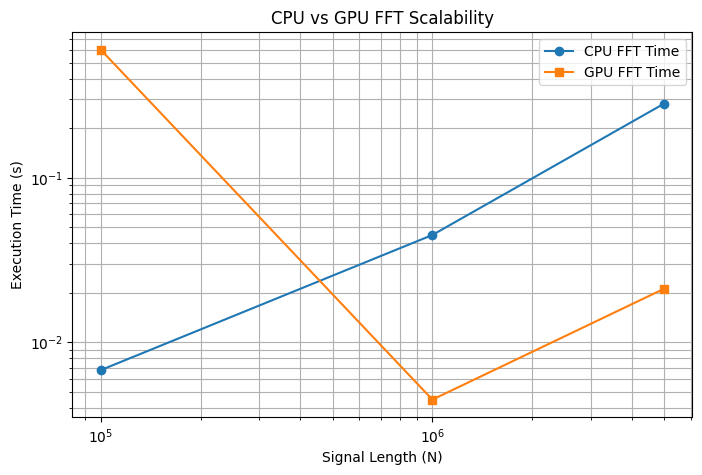

In [4]:
#Run and Analysis for Multiple Lengths
sizes = [10**5, 10**6, 5*10**6]
results = []

for N in sizes:
    print(f"\n=== Testing N = {N} ===")
    signal, fs = generate_signal(N)
    fft_cpu, fft_gpu, cpu_time, gpu_time = compare_fft(signal)

    print(f"CPU FFT Time: {cpu_time:.4f} s")
    print(f"GPU FFT Time: {gpu_time:.4f} s")

    plot_spectrum(fft_cpu, fs, N, f"CPU FFT Magnitude Spectrum (N={N})")
    plot_spectrum(fft_gpu, fs, N, f"GPU FFT Magnitude Spectrum (N={N})")

    results.append((N, cpu_time, gpu_time))

    # Plot spectrum for the smallest size (avoid plotting huge data for 5e6)
    if N == 10**5 :
        plot_spectrum(fft_cpu, fs, N, f"CPU FFT Magnitude Spectrum (N={N})")
        plot_spectrum(fft_gpu, fs, N, f"GPU FFT Magnitude Spectrum (N={N})")

Ns, cpu_times, gpu_times = zip(*results)

plt.figure(figsize=(8,5))
plt.plot(Ns, cpu_times, marker='o', label="CPU FFT Time")
plt.plot(Ns, gpu_times, marker='s', label="GPU FFT Time")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Signal Length (N)")
plt.ylabel("Execution Time (s)")
plt.title("CPU vs GPU FFT Scalability")
plt.legend()
plt.grid(True, which="both")
plt.show()

Discuss the scalability of CPU vs. GPU implementations

After running the above code:
- CPU FFT is fast for small arrays but scales poorly.
- GPU FFT has overhead (data transfer to GPU) but excels with large arrays.
- For length = 10⁵, CPU might be faster.
- For length = 10⁶ and 5×10⁶, GPU will likely outperform CPU significantly.